In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))

import config
from evaluate import get_results, plot_confusion_matrix_multiclass, compute_plot_roc_multiclass

from sklearn.utils import shuffle, class_weight
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

# NB: clean up model output folder structure

In [2]:
# Extra imports
import feat_util
import librosa
import matplotlib.pyplot as plt

In [3]:
library = 'PyTorch'

if library == 'PyTorch':
#     import config_pytorch
    from PyTorch.runTorchMultiClass import train_model, load_model, evaluate_model
elif library == 'Keras':
    from tensorflow import keras
    import config_keras
    from runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

ResNet super init self, dropout:  0.2 0.2


In [4]:
# Select IHI Tanzania cup data to use for multi-species classification

df = pd.read_csv(config.data_df)
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [5]:
# Select list of classes with sufficient samples for significant analysis. Ordered with similar groups in adjacent classes.

classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus']

# Create features (only re-run if not loading from pickle)

In [6]:
import collections
species_dict = collections.OrderedDict()
species_recordings = collections.OrderedDict()
for species in classes:
    # Number of total audio clips per species (includes repeats from same filename)
    species_recordings[species] = len(pd.unique(df_all[df_all.species==species].name)) # Number of unique audio recordings (and hence mosquitoes)
    species_dict[species] = sum(df_all[df_all.species==species].length)

In [7]:
# Divide recordings into train and test, with recording shuffling fixed by random_state
train_fraction = 0.75
train_recordings = {}
test_recordings = {}

for i in range(len(classes)):
    n_train = int(species_recordings[classes[i]] * train_fraction)
    n_test = species_recordings[classes[i]] - n_train
    print(classes[i], n_train, n_test)
    df_class = df_all[df_all.species == classes[i]]
    # !!!I think it is probably best to shuffle these to mimic W but need to make sure each ID of mosquito is unique per recording
    train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=42)[:n_train]  
    test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=42)[n_train:]

an arabiensis 385 129
culex pipiens complex 252 84
ae aegypti 36 13
an funestus ss 186 62
an squamosus 68 23
an coustani 37 13
ma uniformis 57 19
ma africanus 28 10


In [6]:
def get_feat_multispecies(df_all, label_recordings_dict, data_dir, rate, n_feat):
    '''Extract features for multi-class species classification.'''
    X = []
    y = []

    for class_label in label_recordings_dict.keys(): # Loop over classes
        print('Extracting features for class:', class_label)
        for i in label_recordings_dict[class_label]: # Loop over recordings in class
            df_match = df_all[df_all.name == i]
            for idx, row in df_match.iterrows(): # Loop over clips in recording
                _, file_format = os.path.splitext(row['name'])
                filename = os.path.join(data_dir, str(row['id']) + file_format)
                signal, rate = librosa.load(filename, sr=rate)
                feat = librosa.feature.melspectrogram(signal, sr=rate, n_mels=n_feat) 
#                 feat = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=n_feat)
                feat = librosa.power_to_db(feat, ref=np.max)
                if config.norm_per_sample:
                    feat = (feat-np.mean(feat))/np.std(feat)                
                X.append(feat)
                y.append(class_label)
    return X, y

In [39]:
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Extracting features for class: 0


 12%|██████████▍                                                                        | 1/8 [01:49<12:44, 109.23s/it]

Extracting features for class: 1


 25%|█████████████████████                                                               | 2/8 [02:47<07:54, 79.14s/it]

Extracting features for class: 2


 38%|███████████████████████████████▌                                                    | 3/8 [02:57<03:58, 47.63s/it]

Extracting features for class: 3


 50%|██████████████████████████████████████████                                          | 4/8 [03:49<03:18, 49.54s/it]

Extracting features for class: 4


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:07<01:53, 37.93s/it]

Extracting features for class: 5


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [04:17<00:56, 28.43s/it]

Extracting features for class: 6


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [04:27<00:22, 22.50s/it]

Extracting features for class: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:34<00:00, 34.34s/it]


In [40]:
# Extract feats, expected runtime ~5 mins
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)
# Extract feats, expected runtime ~14 mins
X_train, y_train = get_feat_multispecies(df_all, train_recordings, config.data_dir, config.rate, config.n_feat)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Extracting features for class: 0


 12%|██████████▍                                                                        | 1/8 [05:26<38:02, 326.00s/it]

Extracting features for class: 1


 25%|████████████████████▊                                                              | 2/8 [08:38<24:43, 247.24s/it]

Extracting features for class: 2


 38%|███████████████████████████████▏                                                   | 3/8 [09:07<12:19, 147.80s/it]

Extracting features for class: 3


 50%|█████████████████████████████████████████▌                                         | 4/8 [11:47<10:09, 152.48s/it]

Extracting features for class: 4


 62%|███████████████████████████████████████████████████▉                               | 5/8 [12:33<05:42, 114.02s/it]

Extracting features for class: 5


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [12:57<02:47, 83.57s/it]

Extracting features for class: 6


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [13:35<01:08, 68.83s/it]

Extracting features for class: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [13:52<00:00, 104.02s/it]


# Save features to pickle

In [41]:
# Save feature output to pickle

import pickle
pickle_name_train = 'log_mel_feat_shuffle_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_test_norm_'+str(config.norm_per_sample)+'.pickle'

log_mel_feat_train = {"X_train":X_train, "y_train":y_train}
log_mel_feat_test = {"X_test":X_test, "y_test":y_test}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(log_mel_feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(log_mel_feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

Saved features to: ../outputs/features/multi-species/humbugdb\for_diff_log_mel_feat_shuffle_train_norm_True.pickle
Saved features to: ../outputs/features/multi-species/humbugdb\for_diff_log_mel_feat_shuffle_test_norm_True.pickle


# Load pickled features

In [6]:
# Load pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'log_mel_feat_shuffle_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_test_norm_'+str(config.norm_per_sample)+'.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    log_mel_feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    log_mel_feat_test = pickle.load(input_file)
    
X_train = log_mel_feat_train["X_train"]
y_train = log_mel_feat_train["y_train"]
X_test = log_mel_feat_test["X_test"]
y_test = log_mel_feat_test["y_test"]

In [7]:
# Reshape features to be used with CNN (Keras or PyTorch)

X_train_CNN, y_train_CNN = feat_util.reshape_feat(X_train, y_train, config.win_size, config.step_size)
X_test_CNN, y_test_CNN = feat_util.reshape_feat(X_test, y_test, config.win_size, config.win_size)

(array([31397., 17163.,  2707., 15981.,  4299.,  2223.,  3575.,  1400.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

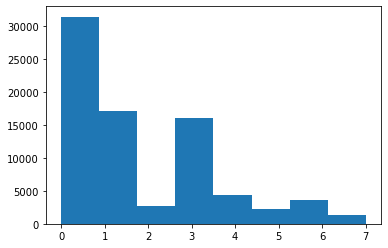

In [49]:
# View class distribution of windows in y label space
plt.hist(y_train_CNN, bins=8)

# Model definition and optimisation
Current model here is identical to the model used in paper for previous results with binary mosquito/noise detection. Acts as good baseline for further work.

## ##TODO: implement PyTorch versions for multiclass

In [8]:
# Compute class weights to weight by inverse of class frequency
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train_CNN),y=y_train_CNN)
# weights = torch.tensor(class_weights)  # Torch does not use dict for class weights
# class_weights = dict(enumerate(class_weights.flatten()))  # Dict to support both older and newer Keras API

# Load model from checkpoint
## (optional)

In [46]:
# Instantiate model to inspect
device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
print(f'Training on {device}')

model = ResnetDropoutFull()
if torch.cuda.device_count() > 1:
    print("Using data parallel")
    model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
model = model.to(device)
# Load trained parameters from checkpoint (may need to download from S3 first)


if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

checkpoint = model.load_state_dict(torch.load(filepath))

Training on cuda:0
ResNet super init self, dropout:  0.2 0.2


In [45]:
# Select checkpoint to load model (optional)
# Following filepath used for results on 26/07/: model results from paper
# filepath = '../outputs/models/keras_Multiclass/Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'

# ResNet-50 BNN
# filepath = '../outputs/models/pytorch/model_e72_2021_07_29_22_10_30.pth'

#30th July overnight training:
filepath = '../outputs/models/pytorch/model_e77_2021_07_30_04_49_13.pth'



model = load_model(filepath)


# Predict and visualise

In [ ]:
model = train_model(X_train_CNN, y_train_CNN, class_weight = class_weights)

Training on cuda:0
Applying class weights: [0.31350527 0.57350842 3.63617473 0.61592673 2.28963131 4.4278565
 2.75332168 7.03080357]
all_y all_y_pred (78745, 1) (78745,)
Saving model to: ..\outputs\models\pytorch\model_e0_2021_07_30_10_45_31.pth
Epoch: 0, Train Loss: 1.84547042, Train Acc: 0.32289034, overrun_counter 0
all_y all_y_pred (78745, 1) (78745,)
Saving model to: ..\outputs\models\pytorch\model_e1_2021_07_30_10_49_17.pth
Epoch: 1, Train Loss: 1.72164529, Train Acc: 0.39519970, overrun_counter 0
all_y all_y_pred (78745, 1) (78745,)
Saving model to: ..\outputs\models\pytorch\model_e2_2021_07_30_10_53_04.pth
Epoch: 2, Train Loss: 1.65557388, Train Acc: 0.43786907, overrun_counter 0
all_y all_y_pred (78745, 1) (78745,)
Saving model to: ..\outputs\models\pytorch\model_e3_2021_07_30_10_56_50.pth
Epoch: 3, Train Loss: 1.62726576, Train Acc: 0.45982602, overrun_counter 0
all_y all_y_pred (78745, 1) (78745,)
Saving model to: ..\outputs\models\pytorch\model_e4_2021_07_30_11_00_35.pth
Ep

In [ ]:
def test_model(model, test_loader, criterion, device=None):
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        test_loss = 0.0
        model.eval()
        
        all_y = []
        all_y_pred = []
        counter = 1
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            y_pred = model(x).squeeze()
            
            loss = criterion(y_pred, y)

            test_loss += loss.item()
            
            all_y.append(y.cpu().detach())
            all_y_pred.append(y_pred.cpu().detach())
            
            del x
            del y
            del y_pred
            
            counter +=1

        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), np.argmax(all_y_pred.numpy(), axis=1))
    

In [47]:
preds_list = evaluate_model(model,X_test_CNN,y_test_CNN,30)

Evaluating on cuda:0
0.5933065028595637
0.5969074348654946
0.5992374496928616
0.5962719762762126
0.5969074348654946
0.5935183223893243
0.5897055708536327
0.6060156746452023
0.5977547129845372
0.5916119466214785
0.5986019911035797
0.5920355856809998
0.5941537809786063
0.5916119466214785
0.5975428934547765
0.5977547129845372
0.5941537809786063
0.593094683329803
0.5994492692226223
0.5950010590976488
0.5920355856809998
0.5939419614488456
0.5926710442702817
0.593094683329803
0.5975428934547765
0.5909764880321966
0.5928828638000424
0.5971192543952553
0.6000847278119043
0.5914001270917179


PyTorch sampled
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1890
           1       0.56      0.58      0.57      1000
           2       0.66      0.69      0.67       175
           3       0.70      0.76      0.73       928
           4       0.36      0.42      0.39       275
           5       0.26      0.22      0.24       159
           6       0.26      0.27      0.27       172
           7       0.27      0.24      0.25       122

    accuracy                           0.62      4721
   macro avg       0.48      0.48      0.48      4721
weighted avg       0.62      0.62      0.62      4721



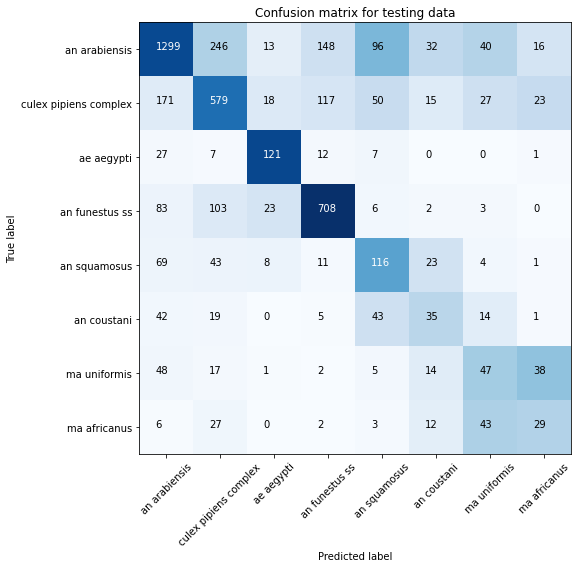

In [43]:
# PyTorch

print('PyTorch sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1)))

In [9]:
# Sample predictions from BNN. To save time, when analysing quick configurations, set samples to N=10

BNN_samples = 3
preds_list = []
for i in range(BNN_samples):
    preds_values = model.predict(X_test_CNN)
    preds_list.append(preds_values)

AttributeError: 'ResnetDropoutFull' object has no attribute 'predict'

BNN sampled
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1890
           1       0.61      0.56      0.59      1000
           2       0.75      0.65      0.70       175
           3       0.67      0.76      0.71       928
           4       0.39      0.49      0.43       275
           5       0.20      0.10      0.13       159
           6       0.41      0.48      0.44       172
           7       0.38      0.20      0.26       122

    accuracy                           0.64      4721
   macro avg       0.52      0.50      0.50      4721
weighted avg       0.63      0.64      0.63      4721



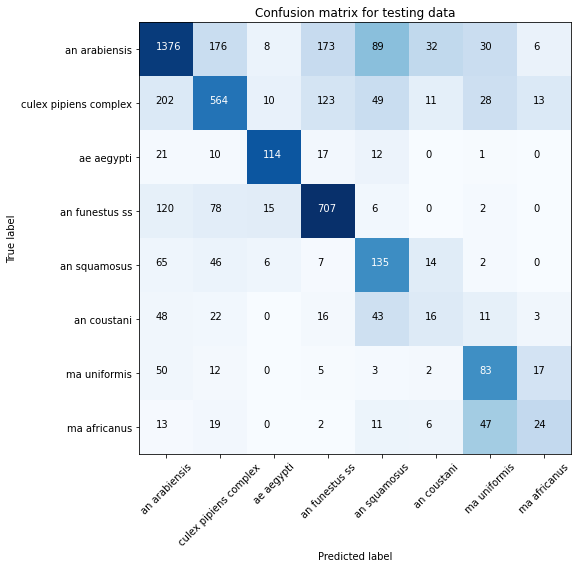

In [15]:
print('BNN sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1)))


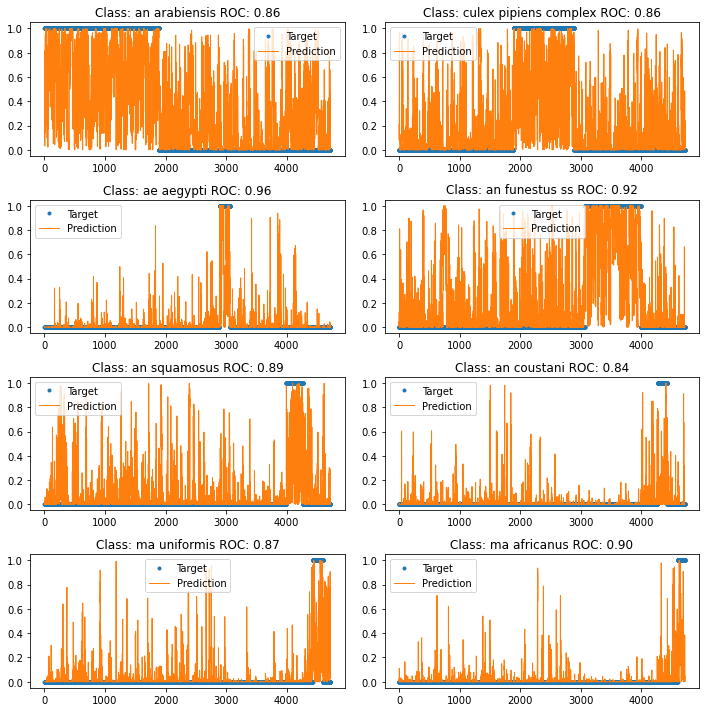

In [44]:
import sklearn
from evaluate import to_categorical
# debug multi ROC:

y_pred_prob = np.mean(preds_list,axis=0)
y_true = y_test_CNN

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], thresholds = sklearn.metrics.roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
    

fig, axes = plt.subplots(4,2, figsize=(10,10))
for species_idx, ax in enumerate(axes.ravel()):
    ax.plot(to_categorical(y_true)[:,species_idx],'.',label='Target')
    ax.plot(y_pred_prob[:,species_idx], label='Prediction',lw=1)
    ax.set_title('Class: ' + classes[species_idx] + ' ROC: ' + '{:.2f}'.format(roc_auc[species_idx]))
    ax.legend()
plt.tight_layout()

BNN
{0: 0.8223034282200654, 1: 0.8222688793335126, 2: 0.9237634341021935, 3: 0.9137641253852378, 4: 0.8463812211180632, 5: 0.794850267040551, 6: 0.8310911674940059, 7: 0.8145017270326051, 'micro': 0.9019087710520854}


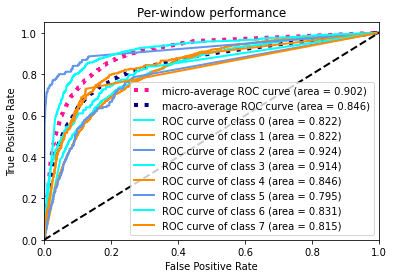

In [48]:
compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')

# Evaluate performance per recording (extension)

In [227]:
def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, _ = feat_util.reshape_feat([recording], [y_test[idx]], config.win_size, config.step_size)
        for i in range(BNN_samples):
            preds_values = model.predict(X_item)
            preds_list.append(preds_values)
        preds_values = np.mean(preds_list,axis=0)
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean

In [228]:
preds_aggregated_by_mean, y_aggregated_prediction_by_mean = evaluate_aggregate_predictions(X_test, y_test, model, 100)

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       200
           1       0.68      0.67      0.67       136
           2       1.00      0.42      0.59        24
           3       0.76      0.79      0.77        94
           4       0.60      0.33      0.43        36
           5       0.43      0.13      0.20        23
           6       0.39      0.43      0.41        30
           7       0.25      0.09      0.13        22

    accuracy                           0.66       565
   macro avg       0.60      0.46      0.49       565
weighted avg       0.65      0.66      0.64       565



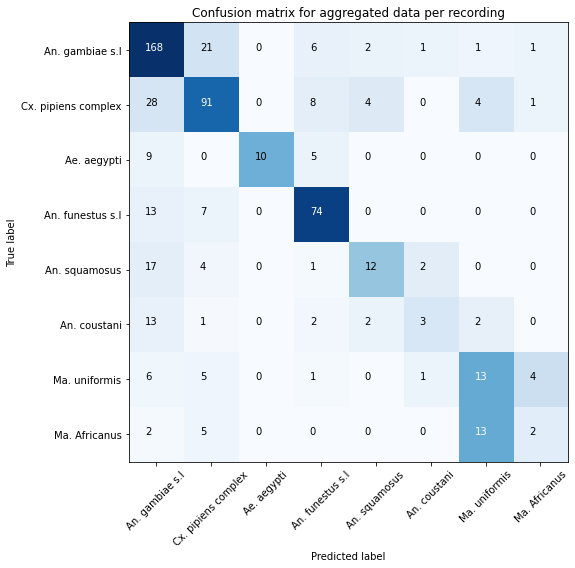

In [229]:
cnf_matrix = confusion_matrix(y_test, y_aggregated_prediction_by_mean)
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for aggregated data per recording', classes)
print(classification_report(y_test, y_aggregated_prediction_by_mean))

BNN
{0: 0.8787260273972602, 1: 0.8697038255861785, 2: 0.9205175600739371, 3: 0.9499028775353481, 4: 0.9035916824196597, 5: 0.9159313332263757, 6: 0.9117757009345795, 7: 0.9384731290808639, 'micro': 0.9289824687021022}


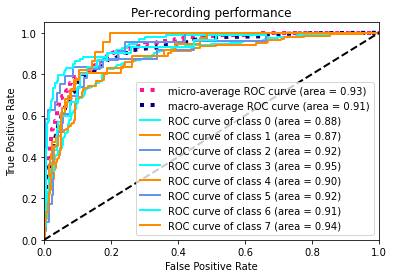

In [245]:
compute_plot_roc_multiclass(y_test,np.array(preds_aggregated_by_mean), classes, title='Per-recording performance')